In [1]:
import os
import sys
sys.path.append(os.path.abspath('../src'))

import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import torch
import gpytorch as gp
from botorch.models import FixedNoiseGP, SingleTaskGP
from botorch.fit import fit_gpytorch_model
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood

from fixed_noise_gp import get_gp, train_gp, predict

In [4]:
df = pd.read_csv('../data/diblock/diblock.csv')

In [5]:
X1 = np.array(df.loc[:,'x1']).astype(np.float64)
X2 = np.array(df.loc[:,'x2']).astype(np.float64)
X = np.vstack((X1, X2)).T

X = torch.from_numpy(X).to(torch.float64)

Y = np.array(df.loc[:,'rg_mean'])
Y = torch.from_numpy(Y).to(torch.float64).unsqueeze(-1)

noise = np.array(np.square(df.loc[:,'rg_std']))
noise = torch.from_numpy(noise).to(torch.float64).unsqueeze(-1)

In [6]:
torch.manual_seed(42)
n = X.shape[0]
perm = torch.randperm(n)
train_idx = perm[:100]
test_idx = perm[100:]

In [7]:
train_X = X[train_idx]
train_Y = Y[train_idx]
train_noise = noise[train_idx]

test_X = X[test_idx]
test_Y = Y[test_idx]
test_noise = noise[test_idx]

In [8]:
test_df = df.iloc[test_idx]

In [9]:
model = get_gp(train_X, train_Y, train_noise)
model = train_gp(model)

In [10]:
with torch.no_grad():
    posterior = model.posterior(test_X)
    pred_mean = posterior.mean.squeeze()
    pred_var = posterior.variance.squeeze()

In [11]:
def plot_ypred_vs_ytrue(ypred, ytrue):
    plt.figure(figsize=(8, 8))
    plt.scatter(ytrue, ypred, alpha=0.6)
    plt.xlabel('True', fontsize=20)
    plt.ylabel('Predicted', fontsize=20)
    plt.tick_params(axis='both', labelsize=16)
    plt.plot([ytrue.min(), ytrue.max()], [ytrue.min(), ytrue.max()], 'r--')
    plt.show()

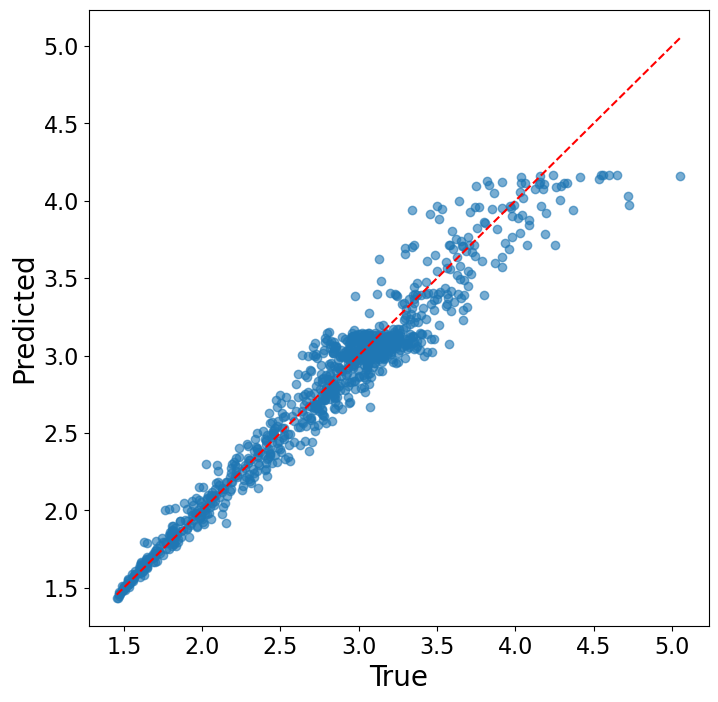

In [12]:
plot_ypred_vs_ytrue(pred_mean.detach().numpy(), test_Y)

In [13]:
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(test_Y, pred_mean.detach().numpy())
rmse = np.sqrt(mean_squared_error(test_Y, pred_mean.detach().numpy()))

print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

R²: 0.9480
RMSE: 0.1551


In [14]:
from UQtools import order_sig_and_errors, get_slope_metric, spearman_rank_corr, expected_rho, calibration_curve, calibration_area, plot_calibration_curve, plot_Z_scores, NLL

In [15]:
data = np.column_stack((test_Y.detach().numpy(), pred_mean.detach().numpy(), np.sqrt(pred_var.detach().numpy())))
df_uq = pd.DataFrame(data, columns=['test_y', 'pred_y', 'uq'])

df = pd.DataFrame(data, columns=['test_y', 'pred_y', 'uq'])
df['error'] = df['pred_y'] - df['test_y']

In [16]:
df

,test_y,pred_y,uq,error
0,3.020090,3.074875,0.031408,0.054785
1,2.723646,3.084487,0.109653,0.360842
2,1.646428,1.629894,0.030338,-0.016534
3,2.623831,2.539331,0.021453,-0.084500
4,2.550752,2.495229,0.033572,-0.055523
...,...,...,...,...
915,4.020607,3.888728,0.049116,-0.131880
916,2.744313,2.644238,0.039004,-0.100075
917,2.536614,2.730281,0.035160,0.193667
918,2.938480,2.995575,0.030803,0.057095


rho_rank = 0.42
rho_rank_sim = 0.45 +/- 0.03
miscalibration area = 0.31
NLL = 4.50
NLL_sim = -1.92 +/- 0.02
R squared: 0.7086653952180069
intercept: 0.052028626014112664
slope: 2.227751258524814


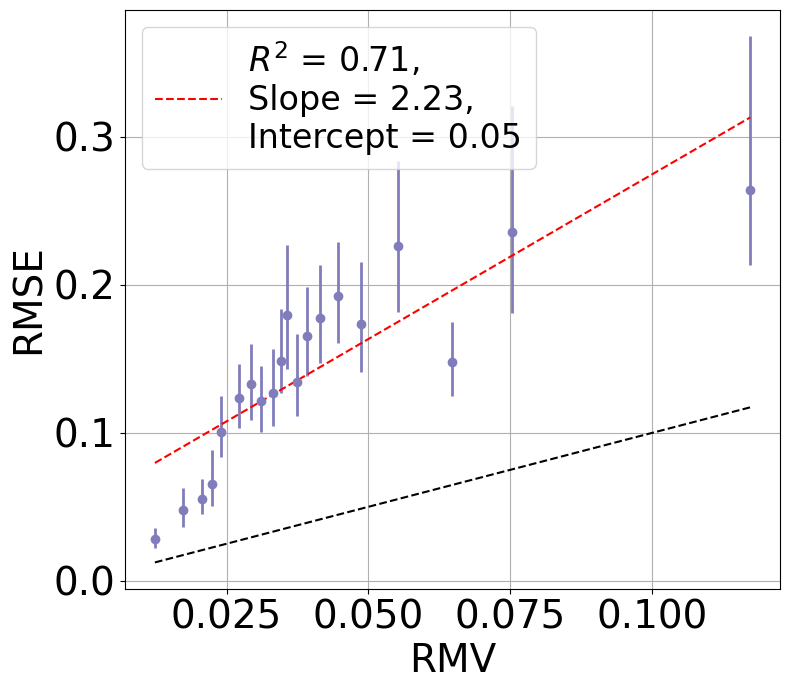

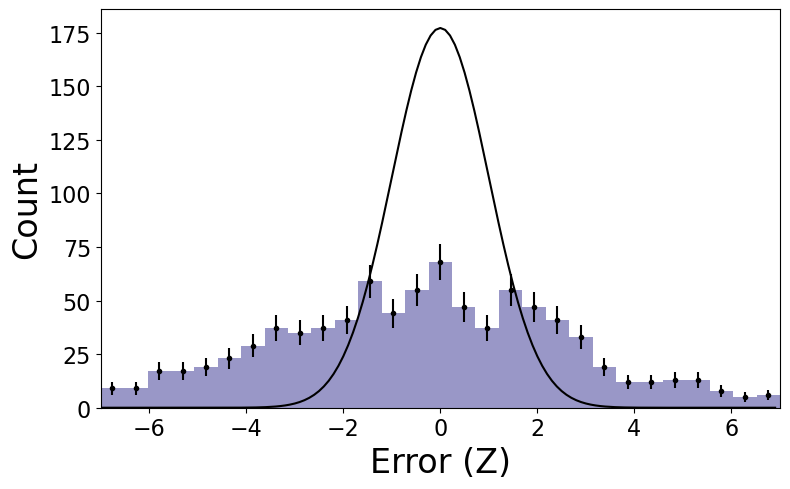

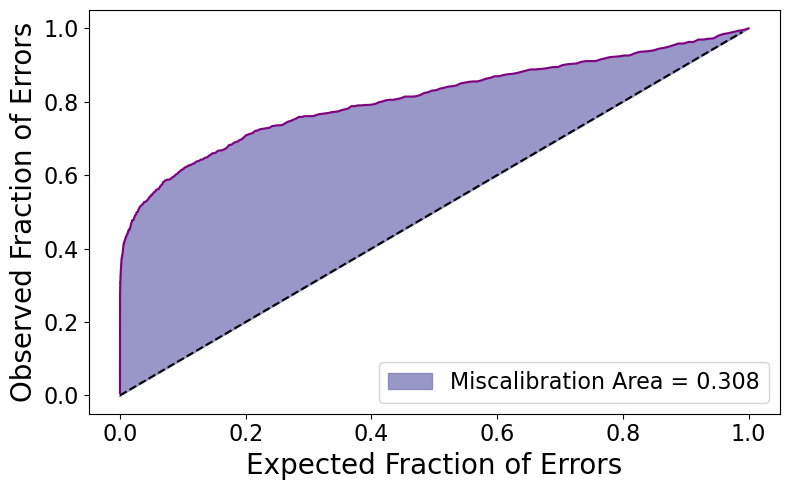

In [17]:
#Order uncertainties and errors according to uncertainties
ordered_df = order_sig_and_errors(df.uq, df.error)

#Calculate rho_rank and rho_rank_sim
rho_rank, _ = spearman_rank_corr(np.abs(df.error), df.uq)
print(f'rho_rank = {rho_rank:.2f}')
exp_rhos_temp = []
for i in range(1000):
    exp_rho, _ = expected_rho(df.uq)
    exp_rhos_temp.append(exp_rho)
rho_rank_sim = np.mean(exp_rhos_temp)
rho_rank_sim_std = np.std(exp_rhos_temp)
print(f'rho_rank_sim = {rho_rank_sim:.2f} +/- {rho_rank_sim_std:.2f}')

#Calculate the miscalibration area
gaus_pred, errors_observed = calibration_curve(ordered_df.abs_z)
mis_cal = calibration_area(errors_observed, gaus_pred)
print(f'miscalibration area = {mis_cal:.2f}')

#Calculate NLL and simulated NLL
_NLL = NLL(df.uq, df.error)
print(f'NLL = {_NLL:.2f}')
exp_NLL = []
for i in range(1000):
    sim_errors = []
    for sigma in df.uq:
        sim_error = np.random.normal(0, sigma)
        sim_errors.append(sim_error)
    NLL_sim = NLL(df.uq, sim_errors)
    exp_NLL.append(NLL_sim)
NLL_sim = np.mean(exp_NLL)
NLL_sim_std = np.std(exp_NLL)
print(f'NLL_sim = {NLL_sim:.2f} +/- {NLL_sim_std:.2f}')

#Generate error-based calibration plot
fig, slope, R_sq, intercept = get_slope_metric(ordered_df.uq, ordered_df.errors, Nbins=20)

#Generate Z-score plot and calibration curve
fig2, ax2 = plot_Z_scores(ordered_df.errors, ordered_df.uq)
fig3 = plot_calibration_curve(gaus_pred, errors_observed, mis_cal)